In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
# max_seq_len = 64
# batch_size = 64
# dataset_size = 2000
# with_mask = False

# train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
#                                                                                                  with_mask=with_mask,
#                                                                                                  split_ratio=0.2,
#                                                                                                  dataset_size=dataset_size,
#                                                                                                  max_seq_len=max_seq_len,
#                                                                                                  train=True)

# # train_tokens, val_tokens = train_tokens[:, :, :2].contiguous(), val_tokens[:, :, :2].contiguous()

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [3]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

# test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
#                                                             with_mask=with_mask,
#                                                             max_seq_len=max_seq_len,
#                                                             dataset_size=500,
#                                                             train=False)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

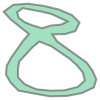

In [4]:
from utils.vector2shape import reverse_vector_polygon
reverse_vector_polygon(train_tokens[11])

In [ ]:
train_tokens[10]

In [23]:
# from typing import Optional, Any, Union, Callable


# from torch import Tensor
# from torch.nn import functional as F


# class Hierachy_TransformerEncoderLayer(nn.TransformerEncoderLayer):
#     def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dim_ffn_output = 512, dropout: float = 0.1, activation: str | Callable[[Tensor], Tensor] = F.relu, layer_norm_eps: float = 0.00001, batch_first: bool = False, norm_first: bool = False, device=None, dtype=None) -> None:
#         super().__init__(d_model, nhead, dim_feedforward, dropout, activation, layer_norm_eps, batch_first, norm_first, device, dtype)
#         factory_kwargs = {'device': device, 'dtype': dtype}
#         self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
#                                             **factory_kwargs)
#         # Implementation of Feedforward model
#         self.linear1 = nn.Linear(d_model, dim_feedforward, **factory_kwargs)
#         self.dropout = nn.Dropout(dropout)
#         self.linear2 = nn.Linear(dim_feedforward, dim_ffn_output, **factory_kwargs)

#         self.norm_first = norm_first
#         self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
#         self.norm2 = nn.LayerNorm(dim_ffn_output, eps=layer_norm_eps, **factory_kwargs)
#         self.dropout1 = nn.Dropout(dropout)
#         self.dropout2 = nn.Dropout(dropout)

#         # Legacy string support for activation function.
#         if isinstance(activation, str):
#             activation = _get_activation_fn(activation)

#         # We can't test self.activation in forward() in TorchScript,
#         # so stash some information about it instead.
#         if activation is F.relu or isinstance(activation, torch.nn.ReLU):
#             self.activation_relu_or_gelu = 1
#         elif activation is F.gelu or isinstance(activation, torch.nn.GELU):
#             self.activation_relu_or_gelu = 2
#         else:
#             self.activation_relu_or_gelu = 0
#         self.activation = activation

#     def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
#                 src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
#         r"""Pass the input through the encoder layer.

#         Args:
#             src: the sequence to the encoder layer (required).
#             src_mask: the mask for the src sequence (optional).
#             src_key_padding_mask: the mask for the src keys per batch (optional).

#         Shape:
#             see the docs in Transformer class.
#         """

#         if src_key_padding_mask is not None:
#             _skpm_dtype = src_key_padding_mask.dtype
#             if _skpm_dtype != torch.bool and not torch.is_floating_point(src_key_padding_mask):
#                 raise AssertionError(
#                     "only bool and floating types of key_padding_mask are supported")
#         # see Fig. 1 of https://arxiv.org/pdf/2002.04745v1.pdf
#         why_not_sparsity_fast_path = ''
#         if not src.dim() == 3:
#             why_not_sparsity_fast_path = f"input not batched; expected src.dim() of 3 but got {src.dim()}"
#         elif self.training:
#             why_not_sparsity_fast_path = "training is enabled"
#         elif not self.self_attn.batch_first :
#             why_not_sparsity_fast_path = "self_attn.batch_first was not True"
#         elif not self.self_attn._qkv_same_embed_dim :
#             why_not_sparsity_fast_path = "self_attn._qkv_same_embed_dim was not True"
#         elif not self.activation_relu_or_gelu:
#             why_not_sparsity_fast_path = "activation_relu_or_gelu was not True"
#         elif not (self.norm1.eps == self.norm2.eps):
#             why_not_sparsity_fast_path = "norm1.eps is not equal to norm2.eps"
#         elif src_mask is not None:
#             why_not_sparsity_fast_path = "src_mask is not supported for fastpath"
#         elif src.is_nested and src_key_padding_mask is not None:
#             why_not_sparsity_fast_path = "src_key_padding_mask is not supported with NestedTensor input for fastpath"
#         elif self.self_attn.num_heads % 2 == 1:
#             why_not_sparsity_fast_path = "num_head is odd"
#         elif torch.is_autocast_enabled():
#             why_not_sparsity_fast_path = "autocast is enabled"

#         if not why_not_sparsity_fast_path:
#             tensor_args = (
#                 src,
#                 self.self_attn.in_proj_weight,
#                 self.self_attn.in_proj_bias,
#                 self.self_attn.out_proj.weight,
#                 self.self_attn.out_proj.bias,
#                 self.norm1.weight,
#                 self.norm1.bias,
#                 self.norm2.weight,
#                 self.norm2.bias,
#                 self.linear1.weight,
#                 self.linear1.bias,
#                 self.linear2.weight,
#                 self.linear2.bias,
#             )

#             # We have to use list comprehensions below because TorchScript does not support
#             # generator expressions.
#             if torch.overrides.has_torch_function(tensor_args):
#                 why_not_sparsity_fast_path = "some Tensor argument has_torch_function"
#             elif not all((x.is_cuda or 'cpu' in str(x.device)) for x in tensor_args):
#                 why_not_sparsity_fast_path = "some Tensor argument is neither CUDA nor CPU"
#             elif torch.is_grad_enabled() and any(x.requires_grad for x in tensor_args):
#                 why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
#                                               "input/output projection weights or biases requires_grad")

#             if not why_not_sparsity_fast_path:
#                 return torch._transformer_encoder_layer_fwd(
#                     src,
#                     self.self_attn.embed_dim,
#                     self.self_attn.num_heads,
#                     self.self_attn.in_proj_weight,
#                     self.self_attn.in_proj_bias,
#                     self.self_attn.out_proj.weight,
#                     self.self_attn.out_proj.bias,
#                     self.activation_relu_or_gelu == 2,
#                     self.norm_first,
#                     self.norm1.eps,
#                     self.norm1.weight,
#                     self.norm1.bias,
#                     self.norm2.weight,
#                     self.norm2.bias,
#                     self.linear1.weight,
#                     self.linear1.bias,
#                     self.linear2.weight,
#                     self.linear2.bias,
#                     # TODO: if src_mask and src_key_padding_mask merge to single 4-dim mask
#                     src_mask if src_mask is not None else src_key_padding_mask,
#                     1 if src_key_padding_mask is not None else
#                     0 if src_mask is not None else
#                     None,
#                 )


#         x = src
#         if self.norm_first:
#             x = x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
#             x = x + self._ff_block(self.norm2(x))
#         else:
#             x = self.norm1(x + self._sa_block(x, src_mask, src_key_padding_mask))
#             x = self.norm2(self._ff_block(x))

#         return x

# def _get_activation_fn(activation: str) -> Callable[[Tensor], Tensor]:
#     if activation == "relu":
#         return F.relu
#     elif activation == "gelu":
#         return F.gelu

#     raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

In [24]:
# class Pae(nn.Module):
#     def __init__(self, fea_dim=7, d_model=30, num_heads=6, ffn_dim=32, dropout=0.5, max_seq_len=64):
#         super().__init__()


#         self.cls_emb = nn.Parameter(torch.randn(1, 1, d_model))
#         enc_layer1 = Hierachy_TransformerEncoderLayer(d_model=d_model, nhead=6, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=28, dim_ffn_output=18)
#         enc_layer2 = Hierachy_TransformerEncoderLayer(d_model=18, nhead=3, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=12, dim_ffn_output=8)
#         enc_layer3 = Hierachy_TransformerEncoderLayer(d_model=8, nhead=2, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=4, dim_ffn_output=1)
        
#         self.enc_layers = [enc_layer1, enc_layer2, enc_layer3]
        
#         dec_layer1 = Hierachy_TransformerEncoderLayer(d_model=1, nhead=1, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=4, dim_ffn_output=8)
#         dec_layer2 = Hierachy_TransformerEncoderLayer(d_model=8, nhead=2, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=12, dim_ffn_output=18)
#         dec_layer3 = Hierachy_TransformerEncoderLayer(d_model=18, nhead=3, dropout=dropout, batch_first=True,
#                                                            dim_feedforward=28, dim_ffn_output=d_model)
        
#         self.dec_layers = [dec_layer1, dec_layer2, dec_layer3]
        
#         self.pos_emb = PositionalEncoding(d_model, max_seq_len+1)
#         # self.pos_emb = nn.Parameter(torch.randn(1, 1 + max_seq_len, emb_dim))

#         self.project = nn.Linear(fea_dim, d_model)
#         self.remap = nn.Linear(d_model, fea_dim)

#         self.mse_loss_func = nn.MSELoss()
#         self.meta_loss_func = nn.CrossEntropyLoss()
#         self.render_loss_func = nn.BCELoss()

#     def forward(self, x, mask=None):
#         # input = self.projection_coord(x[:, :, :2]) + self.projection_meta(x[:, :, 2:])
#         input = self.project(x)
#         # print(input.shape)
#         class_emb = self.cls_emb.repeat(input.size(0), 1, 1)
#         # print(class_emb.shape, input.shape)
#         input = torch.cat([class_emb, input], dim=1)
#         input = self.pos_emb(input)

#         hidden = input
#         for enc_layer in self.enc_layers:
#             hidden = enc_layer(hidden)
#         # hidden = self.enc_layers[0](hidden)
#         # hidden = self.enc_layers[1](hidden)

#         decoded = hidden

#         for dec_layer in self.dec_layers:
#             decoded = dec_layer(decoded)
        
#         decoded = decoded[:, 1:, :] # remove cls decoded token
#         decoded = self.remap(decoded)

#         coord_output = decoded[:, :, :2]
#         inner = torch.sigmoid(decoded[:, :, 2])
#         outer = torch.sigmoid(decoded[:, :, 3])
#         meta_output = decoded[:, :, 4:]
#         target_inner = x[:, :, 2]
#         target_outer = x[:, :, 3]
#         target_meta = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
#         coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
#         # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
#         inner_loss = self.render_loss_func(inner.contiguous().view(-1), target_inner.contiguous().view(-1))
#         outer_loss = self.render_loss_func(outer.contiguous().view(-1), target_outer.contiguous().view(-1))
#         meta_loss = self.meta_loss_func(meta_output.contiguous().view(-1, 3), target_meta.contiguous().view(-1))


#         meta_indices = torch.argmax(meta_output, dim=-1)
#         output = torch.cat([coord_output,
#                             torch.round(inner).unsqueeze(-1),
#                             torch.round(outer).unsqueeze(-1),
#                             nn.functional.one_hot(meta_indices, 3)], dim=-1)

#         return hidden[:, 1:, :], output, coord_loss*1 + (inner_loss + outer_loss)*1 + meta_loss*1

In [85]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_seq_len):
        super().__init__()

        pe = torch.zeros(max_seq_len, emb_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if emb_dim % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :-1] # Avoid dismatch dimension for odd d_model
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    

class Pae(nn.Module):
    def __init__(self, fea_dim=7, d_model=36, num_heads=6, ffn_dim=32, dropout=0.5, num_layers=1, max_seq_len=64):
        super().__init__()

        self.cls_emb = nn.Parameter(torch.randn(1, 1, d_model))
        self.enc_layer1 = nn.Sequential(nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Linear(d_model, 18),
                                        # nn.ReLU()
                                        )
        
        self.enc_layer2 = nn.Sequential(nn.TransformerEncoderLayer(d_model=36, nhead=6, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Linear(36, 18),
                                        # nn.ReLU()
                                        )
        
        self.enc_layer3 = nn.Sequential(nn.TransformerEncoderLayer(d_model=36, nhead=9, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Flatten(),
                                        nn.Linear(16*36, 64),
                                        # nn.ReLU()
                                        )

        
        self.dec_layer1 = nn.Sequential(
                                        nn.TransformerEncoderLayer(d_model=36, nhead=9, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True))
        
        self.dec_layer2 = nn.Sequential(nn.Linear(18, 36),
                                        # nn.ReLU(),
                                        nn.TransformerEncoderLayer(d_model=36, nhead=6, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True))
        
        self.dec_layer3 = nn.Sequential(nn.Linear(18, d_model),
                                        # nn.ReLU(),
                                        nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
)

        self.enc_layers = [self.enc_layer1, self.enc_layer2, self.enc_layer3]
        self.dec_layers = [self.dec_layer1, self.dec_layer2, self.dec_layer3]

        
        self.pos_emb = PositionalEncoding(d_model, max_seq_len)
        self.rec = nn.Linear(64, 16*36)
        self.project = nn.Linear(fea_dim, d_model)
        self.remap = nn.Linear(d_model, fea_dim)

        self.mse_loss_func = F.mse_loss
        self.meta_loss_func = nn.CrossEntropyLoss()
        self.render_loss_func = nn.BCELoss()

    def forward(self, x, mask=None):
        input = self.project(x)
        input = self.pos_emb(input)

        hidden = input
        for i, enc_layer in enumerate(self.enc_layers):
            hidden = enc_layer(hidden)
            if i != len(self.enc_layers)-1:
                hidden = hidden.view(hidden.size(0), hidden.size(1)//2, -1) # flatten to decrese seq_len and increase fea dim

        decoded = self.rec(hidden).reshape(input.size(0), 16, 36)
        for i, dec_layer in enumerate(self.dec_layers):
            if i != 0:
                decoded = decoded.view(decoded.size(0), decoded.size(1)*2, -1)
            decoded = dec_layer(decoded)
            
        decoded = self.remap(decoded)

        coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2], reduction="none")
        coord_loss = coord_loss.sum(dim=[1, 2]).mean(dim=[0])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)
        
        # return hidden, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75
        return hidden, output, coord_loss + meta_loss1 + meta_loss2

In [86]:
pae = Pae(fea_dim=7, ffn_dim=64, dropout=0.1)

if USE_GPU:
    pae = pae.to(device)

optimizer = optim.Adam(pae.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epoch = 50
for epoch in range(num_epoch):
    pae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        train_hidden, train_outputs, loss = pae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    pae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = pae(val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

pae.eval()
with torch.no_grad():
    test_hidden, test_outputs, loss = pae(train_tokens)
    test_loss = loss.item()
print(f"Test Loss: {test_loss}")

Epoch 1, Train Loss: 13.771962852478028, Val Loss: 8.141140937805176
Epoch 2, Train Loss: 8.260953159332276, Val Loss: 7.921453952789307
Epoch 3, Train Loss: 7.935716915130615, Val Loss: 7.842069625854492
Epoch 4, Train Loss: 7.815792980194092, Val Loss: 7.826207160949707
Epoch 5, Train Loss: 7.814229507446289, Val Loss: 7.825396537780762
Epoch 6, Train Loss: 7.794951057434082, Val Loss: 7.947300434112549
Epoch 7, Train Loss: 7.767602481842041, Val Loss: 7.7936110496521
Epoch 8, Train Loss: 7.791351547241211, Val Loss: 7.776450157165527
Epoch 9, Train Loss: 7.729597129821777, Val Loss: 7.778574466705322
Epoch 10, Train Loss: 7.756305713653564, Val Loss: 7.872230052947998
Epoch 11, Train Loss: 8.70243070602417, Val Loss: 9.4528226852417
Epoch 12, Train Loss: 8.033992176055909, Val Loss: 7.868122577667236
Epoch 13, Train Loss: 7.66280460357666, Val Loss: 6.918604373931885
Epoch 14, Train Loss: 6.104631462097168, Val Loss: 5.775094032287598
Epoch 15, Train Loss: 5.632799320220947, Val Los

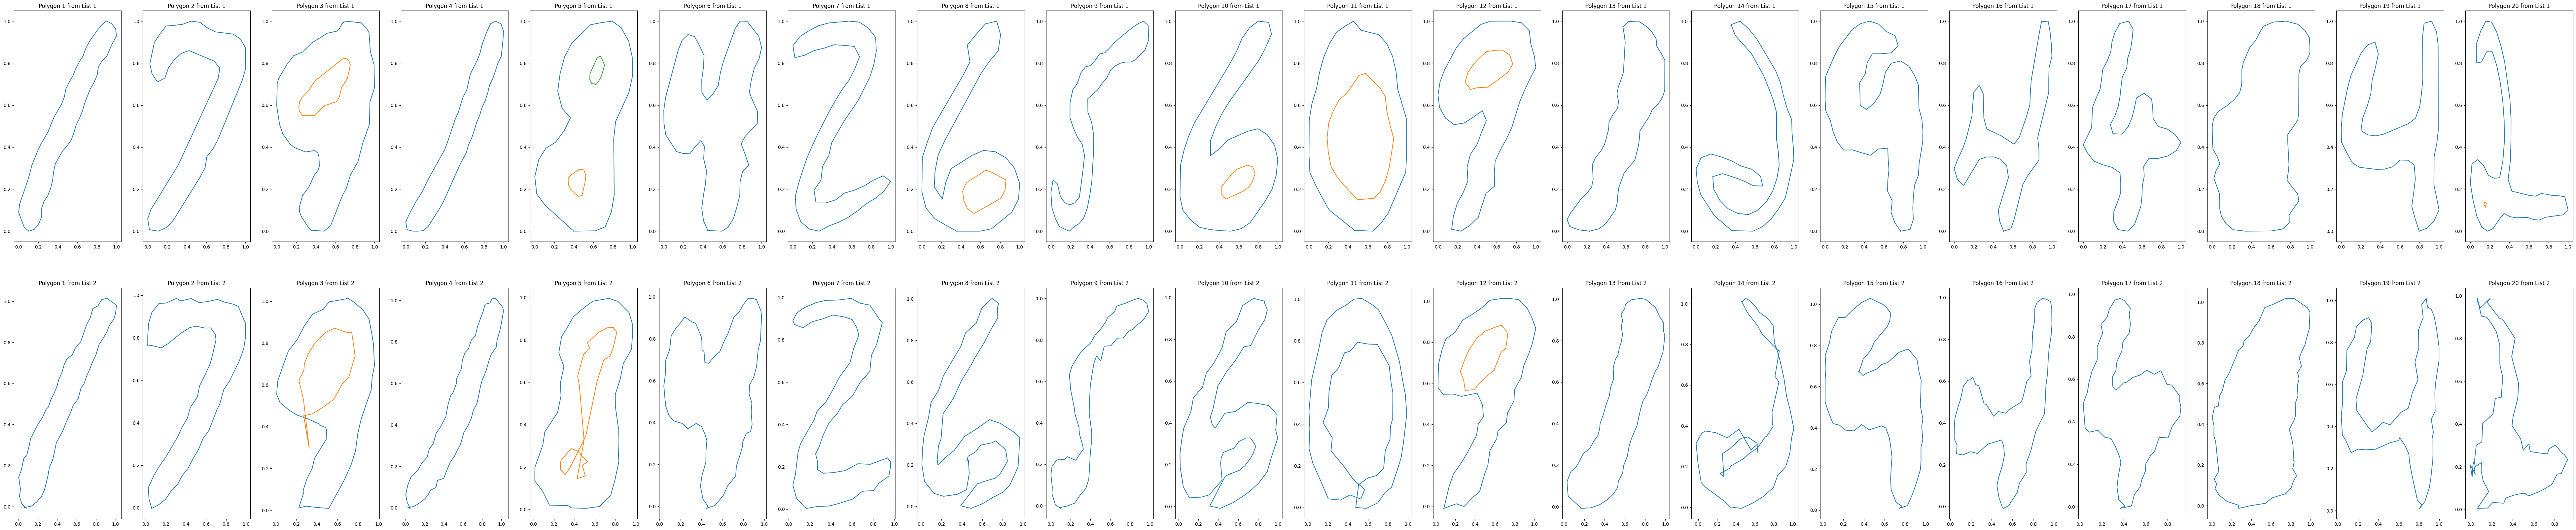

In [87]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

num_samples = 20
show_tokens = val_tokens[:num_samples]
show_outputs = val_outputs[:num_samples]

ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 20))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [88]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = test_hidden.reshape(test_hidden.size(0), -1)
show_labels = train_labels

"Embedding", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Embedding', 0.945625, 0.5123355946517866, 0.6318736535222913)

In [60]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

"Original", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Original', 0.921875, 0.48278103769007996, 0.6189769244956509)

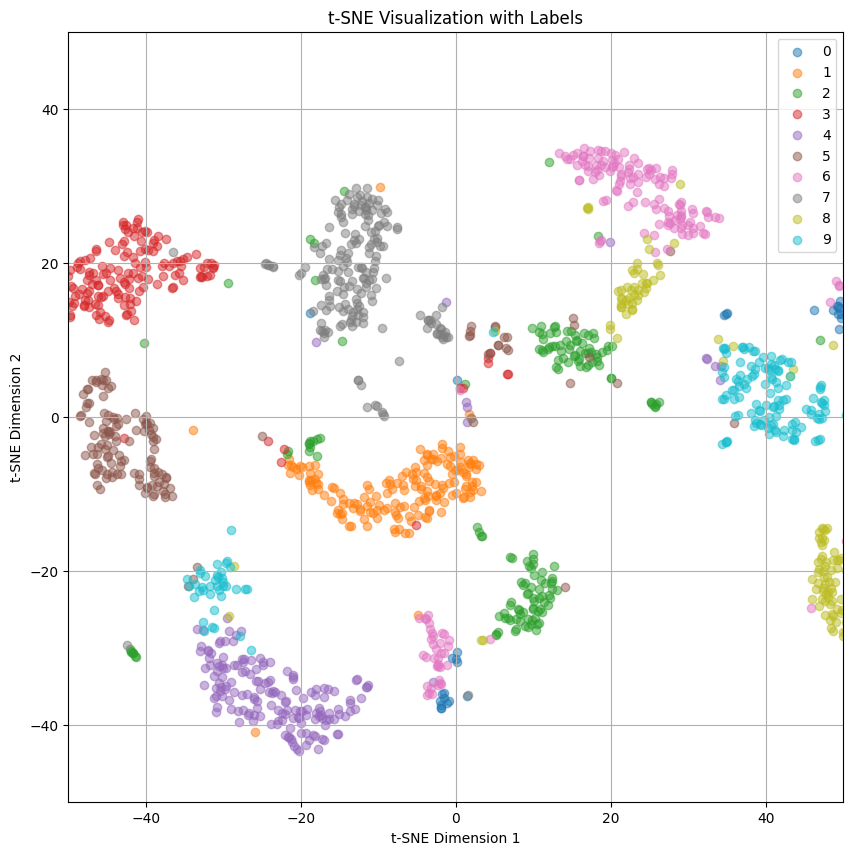

In [89]:
show_hidden = test_hidden.view(test_hidden.size(0), -1)
show_labels = train_labels

# show_hidden = train_tokens.view(train_tokens.size(0), -1).detach().numpy()
# show_labels = train_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
with torch.no_grad():
    cls_train_hidden = pae(train_tokens)[0].reshape(train_tokens.size(0), -1)
    cls_val_hidden = pae(val_tokens)[0].reshape(val_tokens.size(0), -1)

    # tsne = PCA(n_components=64, random_state=0)
    # train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    # val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# cls_train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
# cls_val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(cls_train_hidden, train_labels), batch_size=32, shuffle=True)

In [91]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)
        return x
    
classifier = Classifier(cls_train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, cls_val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 0.6619442580640316, Train Acc 0.81875, Val Loss: 0.3915114104747772, Val Acc: 0.895
Epoch: 2, Train Loss: 0.25844349049031734, Train Acc 0.926875, Val Loss: 0.3400658071041107, Val Acc: 0.9175
Epoch: 3, Train Loss: 0.18136466775089502, Train Acc 0.9475, Val Loss: 0.31176379323005676, Val Acc: 0.9175
Epoch: 4, Train Loss: 0.14086641747504472, Train Acc 0.95125, Val Loss: 0.27692461013793945, Val Acc: 0.925
Epoch: 5, Train Loss: 0.10747620664536953, Train Acc 0.964375, Val Loss: 0.3171831965446472, Val Acc: 0.9125
Epoch: 6, Train Loss: 0.08526465943083167, Train Acc 0.97, Val Loss: 0.341551810503006, Val Acc: 0.92
Epoch: 7, Train Loss: 0.06857724471017718, Train Acc 0.975, Val Loss: 0.32249945402145386, Val Acc: 0.9275
Epoch: 8, Train Loss: 0.09720960782375186, Train Acc 0.97, Val Loss: 0.3696858882904053, Val Acc: 0.925
Epoch: 9, Train Loss: 0.05523157452233136, Train Acc 0.98375, Val Loss: 0.36559563875198364, Val Acc: 0.9275
Epoch: 10, Train Loss: 0.0481341020110